# Imports

In [35]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict

from langchain_groq.chat_models import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from dotenv import load_dotenv
load_dotenv()

True

## Easiest Sequential Workflow

In [22]:
# create a state
class BMIState(TypedDict):
    height: float # in meters
    weight: float # in kg
    bmi: float # bmi value

In [23]:
def calc_bmi(state: BMIState) -> BMIState:
    weight = state['weight']
    height = state['height']
    bmi = weight / (height ** 2)
    # update the key for "bmi"
    # the "reducer" here is update (partial update)
    state['bmi'] = round(bmi, 2)
    return state

In [26]:
# define the graph
graph = StateGraph(BMIState)

# add nodes
graph.add_node(node="calculate_bmi", action=calc_bmi)

# add edges
# START -> calc_bmi -> END
graph.add_edge(START, "calculate_bmi")
graph.add_edge("calculate_bmi", END)

print("graph created...")

graph created...


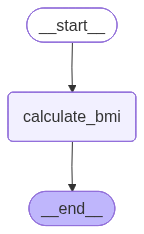

In [27]:
# compile the graph
easiest_sequential_workflow = graph.compile()
# visualise the compiled graph
easiest_sequential_workflow

In [28]:
# execute the graph
initial_state = {"weight":53, "height":1.80}
output_state = easiest_sequential_workflow.invoke(initial_state)

print(f"the final state is {output_state}\nthe bmi is {output_state['bmi']}")

the final state is {'height': 1.8, 'weight': 53, 'bmi': 16.36}
the bmi is 16.36


## Easy Sequential Workflow

In [29]:
class BMIState(TypedDict):
    height: float # in meters
    weight: float # in kg
    bmi: float # bmi value
    category: str # healthy, underweight, overweight, obese

In [30]:
def calc_bmi(state: BMIState) -> BMIState:
    weight = state['weight']
    height = state['height']
    bmi = weight / (height ** 2)
    # update the key for "bmi"
    # the "reducer" here is update (partial update)
    state['bmi'] = round(bmi, 2)
    return state

def label_bmi(state: BMIState) -> BMIState:
    bmi = state['bmi']
    if bmi < 18.5:
        state['category'] = "underweight"
    elif 18.5 <= bmi < 25:
        state['category'] = "normal"
    elif 25 <= bmi < 30:
        state['category'] = "overweight"
    else:
        state['category'] = "obese"
    return state

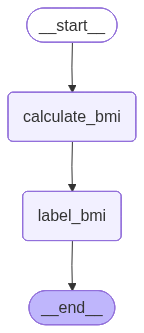

In [31]:
# define the graph
graph = StateGraph(BMIState)

# add nodes
graph.add_node(node="calculate_bmi", action=calc_bmi)
graph.add_node(node="label_bmi", action=label_bmi)

# add edges
# START -> calculate_bmi -> label_bmi -> END
graph.add_edge(START, "calculate_bmi")
graph.add_edge("calculate_bmi", "label_bmi")
graph.add_edge("label_bmi", END)

# compile
easy_sequential_workflow = graph.compile()
easy_sequential_workflow # visualize

In [32]:
initial_state = {"weight":53, "height":1.80}
output_state = easy_sequential_workflow.invoke(initial_state)

print(f"the final state is {output_state}\nthe bmi is {output_state['bmi']}\nthe bmi category is {output_state['category']}")

the final state is {'height': 1.8, 'weight': 53, 'bmi': 16.36, 'category': 'underweight'}
the bmi is 16.36
the bmi category is underweight


## LLM Sequential Workflow

In [36]:
class LLMState(TypedDict):
    """ a simple LLM QnA state consisting of a question and answer """
    question: str
    answer: str

LLM = ChatGroq(model="llama-3.1-8b-instant")

In [38]:
def get_response(state: LLMState) -> LLMState:
    # extract the question
    question = state['question']
    # create the prompt
    prompt = f""" Answer the following question to the best of you knowledge.\n Question: {question} """
    # pass the prompt to the LLM
    answer = LLM.invoke(prompt).content
    # update the state
    state['answer'] = answer
    return state

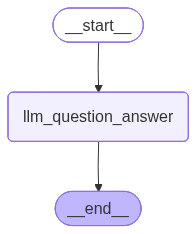

In [41]:
graph = StateGraph(LLMState)

graph.add_node("llm_question_answer", get_response)

graph.add_edge(START, "llm_question_answer")
graph.add_edge("llm_question_answer", END)

llm_qa = graph.compile()
llm_qa

In [40]:
initial_state = {"question": "What is the capital of India?"}
output_state = llm_qa.invoke(initial_state)
print(output_state)

{'question': 'What is the capital of India?', 'answer': 'The capital of India is New Delhi.'}
